In [141]:
import os
import time
from stat import S_ISREG, ST_CTIME, ST_MODE
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


In [166]:
def collate_before_after_inds(inds,df):
    befores=[] # list of lists of before energy readings
    before_idxs=np.unique(np.concatenate([np.arange(max(i-n,0), min(i, len(df))) for i in inds]))
    afters=[] # lists of lists of after energy readings
    after_idxs=np.unique(np.concatenate([np.arange(max(i,0), min(i+n+1, len(df))) for i in inds]))
    
    # collate the before readings
    curr_readings=[] # seed the readings
    idx=0 # index of the readings
    while True:
        # if we are just about to run out if indices
        if idx >= (len(before_idxs)-2):
            last_rows=df.iloc[before_idxs[idx]:before_idxs[idx+1]]
            last_vals=list(last_rows['joules'].array)
            curr_readings+=last_vals
            befores.append(curr_readings) # finish off lists
            break
        this_row=df.iloc[before_idxs[idx]]
        curr_reading=this_row['joules']
        #print('curr_reading'+ str(curr_reading))
        curr_readings+=list([curr_reading])
        if (abs(before_idxs[idx+1]-before_idxs[idx])>1):
            #start new list
            #print('starting new list')
            befores.append(curr_readings)
            curr_readings=[] # reinitialise lists
        idx+=1
        
    # collate the after readings
    curr_readings=[] # seed the readings
    idx=0 # index of the readings
    while True:
        # if we are just about to run out if indices
        if idx >= (len(after_idxs)-2):
            last_rows=df.iloc[after_idxs[idx]:after_idxs[idx+1]]
            last_vals=list(last_rows['joules'].array)
            curr_readings+=last_vals
            afters.append(curr_readings) # finish off lists
            break
        this_row=df.iloc[after_idxs[idx]]
        curr_reading=this_row['joules']
        #print('curr_reading'+ str(curr_reading))
        curr_readings+=list([curr_reading])
        if (abs(after_idxs[idx+1]-after_idxs[idx])>1):
            #start new list
            #print('starting new list')
            afters.append(curr_readings)
            curr_readings=[] # reinitialise lists
        idx+=1     
        
        
        
        
    return zip(befores,afters)
            
        

def collect_before_after_for_project(proj_name,arch):
    succs=[] # list of energy readings before/after successful immigrants
    unsuccs=[] # list of energy readings befor/after unsucessful immigrants
    # for each experimental run
    for i in range(1,11):
        data_file_name='csv/'+proj_name+'_'+str(i)+'.csv'
        df=pd.read_csv(data_file_name)
        dfb=df.loc[df['wasFitter']]  # filter the ones that are fitter
        dfw=df.loc[~df['wasFitter']] # filter the ones that aren't fitter
        ind_succ=dfb.loc[~(dfb['parent'].str.contains(arch))].index
        ind_unsucc=dfw.loc[~(dfw['parent'].str.contains(arch))].index
        #print(ind_succ)
        #print(ind_unsucc)
        if len(ind_succ)>0:
            succs+=collate_before_after_inds(ind_succ,df)
        if len(ind_unsucc)>0:
             unsuccs+=collate_before_after_inds(ind_unsucc,df)
    return (succs,unsuccs)

def collate_means_to_points(means_array):
    # takes in a list of pairs of lists and converts to a list of pairs consisting of the mean of each 
    # array
    res=[(sum(xs)/len(xs),sum(ys)/len(ys)) for (xs,ys) in means_array]
    return res

def print_before_after(means_array):
    # pretty print
    print([(["{0:0.2f}".format(i) for i in xs],["{0:0.2f}".format(i) for i in ys])for (xs,ys) in means_array])

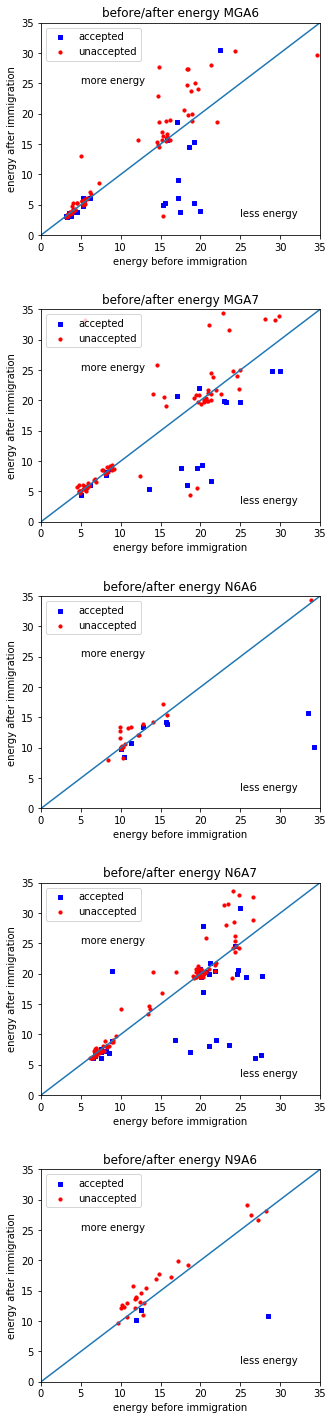

In [203]:

project_strings=[('MGA6','play.M'),('MGA7','play.N'),('N6A6','nexus 6.M'),('N6A7','nexus 6.N'),('N9A6','nexus 9.M')]
#(fig,axs) = plt.subplots(len(project_strings))
fig=plt.figure()
fig.set_figheight(25)
fig.set_figwidth(5)
fig_size=35
#fig.suptitle('Energy use before/after accepted/unaccepted immigrants')
sub_plot_counter=1
for (proj_name,parent_string) in project_strings:
    # collate before/after datapoints for successful (accepted) and unsuccessful (placebo)
    (succs,unsuccs)=collect_before_after_for_project(proj_name,parent_string)
    means=collate_means_to_points(succs)
    xs=[x for (x,y) in means]
    ys=[y for (x,y) in means]
    means=collate_means_to_points(unsuccs)
    uxs=[x for (x,y) in means]
    uys=[y for (x,y) in means]
    
    # start plotting
    ax1 = fig.add_subplot(len(project_strings),1,sub_plot_counter)
    
    #axs[sub_plot_counter].scatter(xs,ys, s=10, c='b', marker="s", label='accepted')
    #axs[sub_plot_counter].scatter(uxs,uys, s=10, c='r', marker="o", label='unaccepted')
    ax1.scatter(xs,ys, s=10, c='b', marker="s", label='accepted')
    ax1.scatter(uxs,uys, s=10, c='r', marker="o", label='unaccepted')
    (xl, yl) = ([0, fig_size], [0, fig_size])
    ax1.plot(xl,yl) # draw 45 degree line
    plt.xlim(0,fig_size)
    plt.ylim(0,fig_size)

    ax1.legend(loc='upper left');
    ax1.set_xlabel('energy before immigration')
    ax1.set_ylabel('energy after immigration')
    ax1.text(5, 25, 'more energy')
    ax1.text(25,3, 'less energy')
    #ax1.annotate('more energy', xy=(15,15), xytext=(5,25),
    #        arrowprops=dict(arrowstyle='<-'), ha='center', va='center')
    #ax1.annotate('less energy', xy=(15,15), xytext=(25,5),
    #        arrowprops=dict(arrowstyle='<-'), ha='center', va='center')
    sub_plot_counter+=1
    plt.title('before/after energy '+proj_name)

fig.subplots_adjust(hspace=0.35)
plt.show()

    
    